In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename)) # otherwise too long
        continue

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = Path('/kaggle/input/siim-isic-melanoma-classification/')
train_path = data_path / 'train'
test_path = data_path / 'test'
print("training_path", train_path)
print("test_path", test_path)

training_path /kaggle/input/siim-isic-melanoma-classification/train
test_path /kaggle/input/siim-isic-melanoma-classification/test


In [4]:
!ls /kaggle/input/siim-isic-melanoma-classification/

jpeg  sample_submission.csv  test  test.csv  tfrecords	train  train.csv


## Images

In [5]:
#!ls /kaggle/input/siim-isic-melanoma-classification/jpeg/train

In [6]:
#!ls /kaggle/input/siim-isic-melanoma-classification/jpeg/test

In [7]:
data_path = Path('/kaggle/input/siim-isic-melanoma-classification/')
im_train_path = data_path / 'jpeg' / 'train'
im_test_path = data_path / 'jpeg' / 'test'
print("train_path: ", im_train_path)
print("test_path:  ", im_test_path)

train_path:  /kaggle/input/siim-isic-melanoma-classification/jpeg/train
test_path:   /kaggle/input/siim-isic-melanoma-classification/jpeg/test


In [8]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

Using TensorFlow backend.


In [9]:
def image_show(im_num,im_folder,im_size):
    """
    MO: Show melanoma images.
    """
    im_ind = 'ISIC'
    im_name = '{}_{}'.format(im_ind,im_num)
    if im_folder=='train':
        im_dir = im_train_path
    elif im_folder=='test':
        im_dir = im_test_path
    im_path = str(im_dir)+'/'+str(im_name)+'.jpg'
    im_path
    
    #from tf.keras.preprocessing.image.load_img
    img = image.load_img(im_path, target_size=(im_size, im_size)) #target_size=(224, 224)
    imgplot = plt.imshow(img)
    print(im_ind,"Image Number:", im_num)
    plt.show()

ISIC Image Number: 5225336


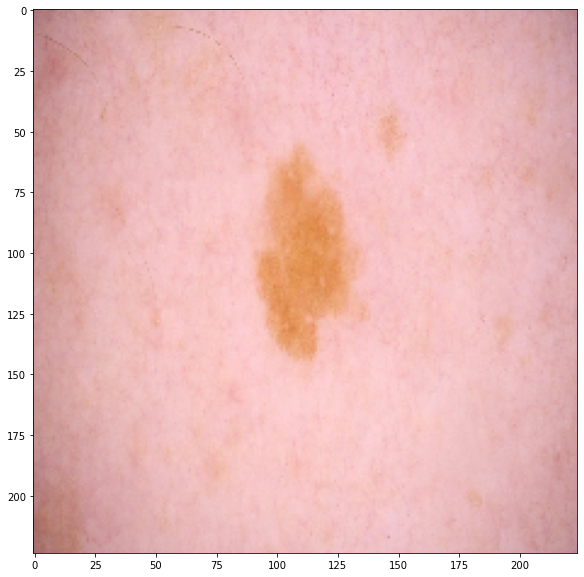

In [10]:
plt.figure(figsize = (10,10))
image_show(5225336,'train',224)

ISIC Image Number: 5224960


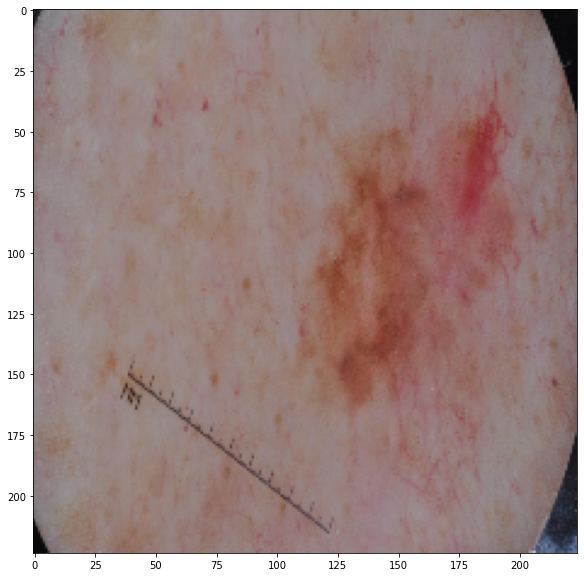

In [11]:
plt.figure(figsize = (10,10))
image_show(5224960,'test',224)

In [12]:
!ls /kaggle/input/siim-isic-melanoma-classification/test/ISIC_5224960.dcm

/kaggle/input/siim-isic-melanoma-classification/test/ISIC_5224960.dcm


In [13]:
#import dicom

import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

PathDicom = '/kaggle/input/siim-isic-melanoma-classification/'
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

Automatically created module for IPython interactive environment


In [14]:
print(lstFilesDCM[0])

/kaggle/input/siim-isic-melanoma-classification/test/ISIC_3024297.dcm


In [15]:
RefDs = pydicom.dcmread(lstFilesDCM[0])
RefDs

(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.5962.99.1.7713.3876.1589909322775.1.1.0.0.0
(0008, 0020) Study Date                          DA: '20200519'
(0008, 0023) Content Date                        DA: '20200519'
(0008, 0030) Study Time                          TM: '172842'
(0008, 0033) Content Time                        TM: '172842'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: '"XC"'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0080) Institution Name                    LO: 'ISDIS'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study Description                   LO: 'ISIC 2020 Grand Challenge image'
(0008, 2218)  Anatomic R

In [16]:
# Get ref file
RefDs = pydicom.dcmread(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print(ConstPixelDims)

(480, 640, 44108)


In [17]:
pat_name = RefDs.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", RefDs.PatientID)
print("Modality.........:", RefDs.Modality)
print("Study Date.......:", RefDs.StudyDate)

Patient's name...: "ISIC, 3024297"
Patient id.......: "ISIC_3024297"
Modality.........: "XC"
Study Date.......: 20200519


Image size.......: 480 x 640, 52412 bytes
Slice location...: (missing)


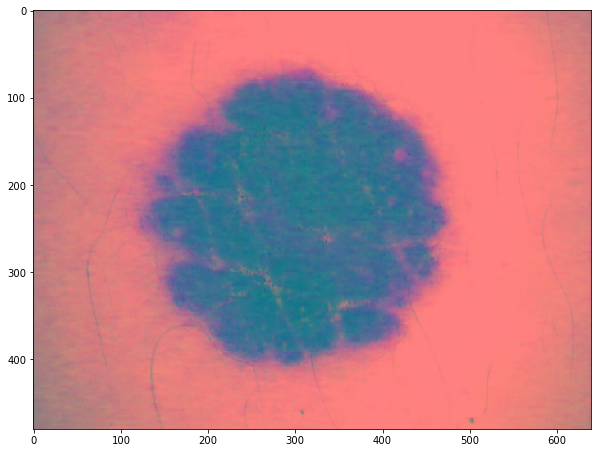

In [18]:
if 'PixelData' in RefDs:
    rows = int(RefDs.Rows)
    cols = int(RefDs.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(rows=rows, cols=cols, size=len(RefDs.PixelData)))
    if 'PixelSpacing' in RefDs:
        print("Pixel spacing....:", RefDs.PixelSpacing) 

        
# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", RefDs.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.figure(figsize = (10,10))
plt.imshow(RefDs.pixel_array, cmap=plt.cm.bone)
plt.show()

## Explore tables

In [19]:
train = pd.read_csv(data_path / 'train.csv')
test  = pd.read_csv(data_path / 'test.csv')
sub   = pd.read_csv(data_path / 'sample_submission.csv')

train.shape, test.shape, sub.shape

((33126, 8), (10982, 5), (10982, 2))

In [20]:
train.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [21]:
train['sex'] = train['sex'].fillna('na')
train['age_approx'] = train['age_approx'].fillna(0)
train['anatom_site_general_challenge'] = train['anatom_site_general_challenge'].fillna('na')

In [22]:
train.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
dtype: int64

In [23]:
train.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0
7,ISIC_0075663,IP_6017204,female,35.0,torso,unknown,benign,0
8,ISIC_0075914,IP_7622888,male,30.0,torso,unknown,benign,0
9,ISIC_0076262,IP_5075533,female,50.0,lower extremity,unknown,benign,0


In [24]:
test.isna().sum()

image_name                         0
patient_id                         0
sex                                0
age_approx                         0
anatom_site_general_challenge    351
dtype: int64

In [25]:
test['anatom_site_general_challenge'] = test['anatom_site_general_challenge'].fillna('na')

In [26]:
test.isna().sum()

image_name                       0
patient_id                       0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
dtype: int64

In [27]:
test.head(10)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,na
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
5,ISIC_0074618,IP_4438996,male,50.0,lower extremity
6,ISIC_0076801,IP_3110660,male,45.0,upper extremity
7,ISIC_0077586,IP_8578442,male,50.0,lower extremity
8,ISIC_0082004,IP_0817448,female,45.0,torso
9,ISIC_0082785,IP_3634181,male,65.0,lower extremity


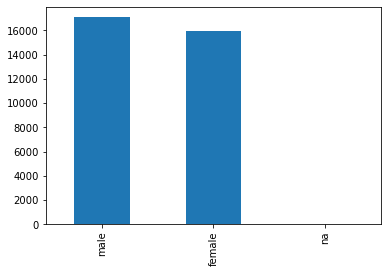

In [28]:
train['sex'].value_counts().plot(kind='bar')

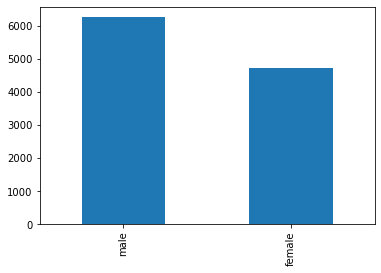

In [29]:
test['sex'].value_counts().plot(kind='bar')

In [30]:
train['sex'].isna().sum()

0

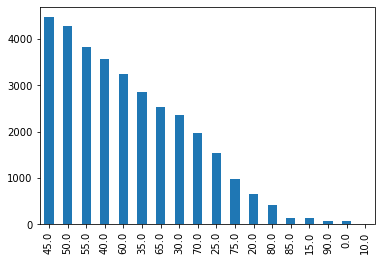

In [31]:
train['age_approx'].value_counts().plot(kind='bar')

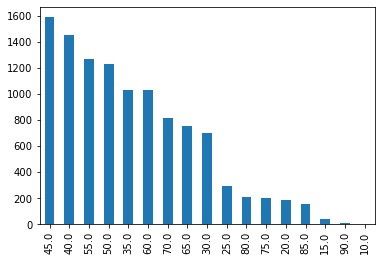

In [32]:
test['age_approx'].value_counts().plot(kind='bar')

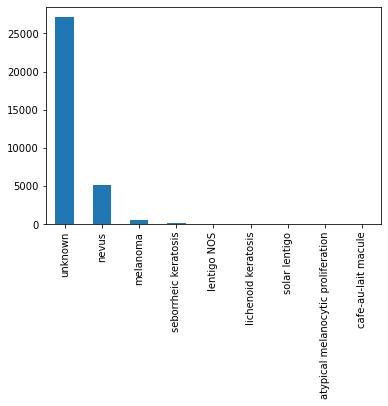

In [33]:
train['diagnosis'].value_counts().plot(kind='bar')

## Melanoma is rare, <2%

In [34]:
train['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

In [35]:
print('Diagnosis                             Percent\n-----------------------------------------------')
print((train['diagnosis'].value_counts() / train['diagnosis'].value_counts().sum() ) *100)

Diagnosis                             Percent
-----------------------------------------------
unknown                               81.881302
nevus                                 15.676508
melanoma                               1.762966
seborrheic keratosis                   0.407535
lentigo NOS                            0.132826
lichenoid keratosis                    0.111695
solar lentigo                          0.021131
atypical melanocytic proliferation     0.003019
cafe-au-lait macule                    0.003019
Name: diagnosis, dtype: float64


## In one plot and save

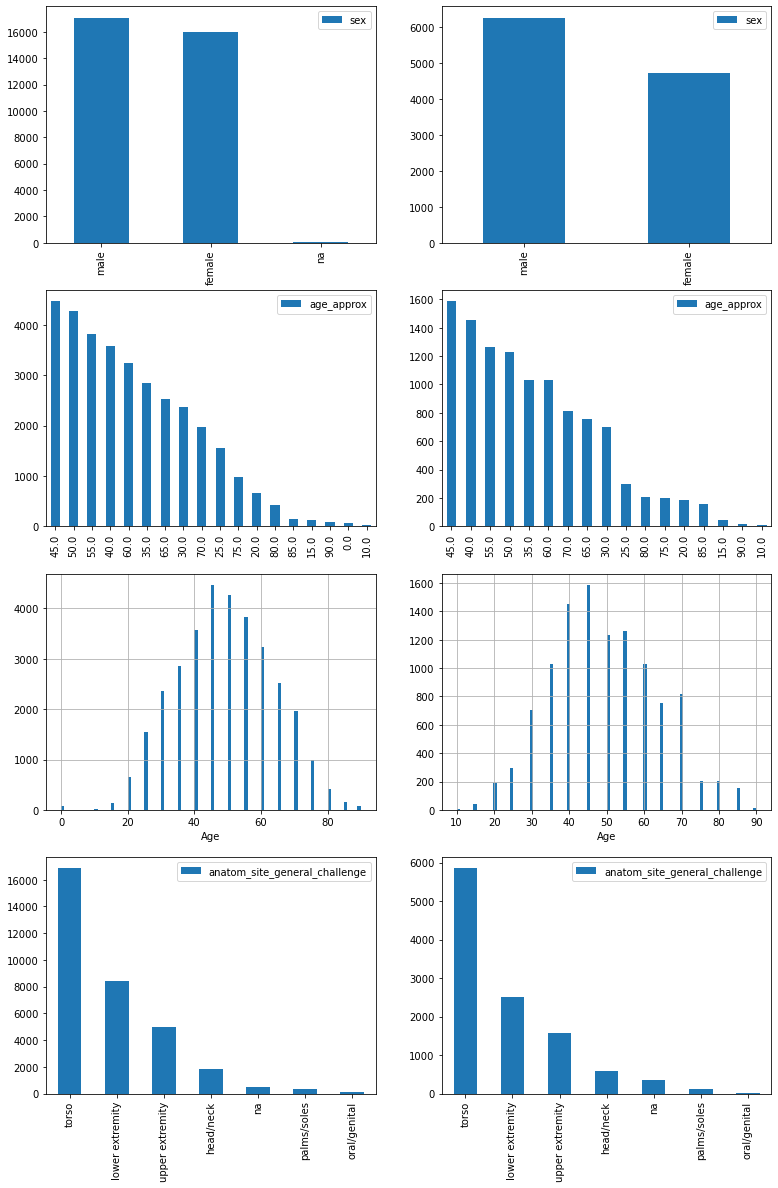

In [36]:
fig, axs = plt.subplots(4,2, figsize=(13,20))

# left train, right test

train['sex'].value_counts().plot(kind='bar', legend=True, ax=axs[0,0])
test['sex'].value_counts().plot(kind='bar', legend=True, ax=axs[0,1])

train['age_approx'].value_counts().plot(kind='bar', legend=True, ax=axs[1,0])
test['age_approx'].value_counts().plot(kind='bar', legend=True, ax=axs[1,1])

train['age_approx'].hist(bins=90, ax=axs[2,0])
test['age_approx'].hist(bins=90, ax=axs[2,1])
axs[2,0].set_xlabel('Age')
axs[2,1].set_xlabel('Age')

train['anatom_site_general_challenge'].value_counts().plot(kind='bar', legend=True, ax=axs[3,0])
test['anatom_site_general_challenge'].value_counts().plot(kind='bar', legend=True, ax=axs[3,1])


plt.savefig('data_sex_age_anatom.png',dpi=100)

plt.show()